<h1 style="color: blue;">*** DRAFT ***</h1>

# Sea ice concentration prediction using large scale modes of climate variability

* Can we relate large-scale climate modes/phenomena (e.g., NOA, CO2, AO, Nino3.4) to Arctic sea ice
* Arctic sea ice concentration (SIC) values range between 0 and 100, with land points represented by -1
* Prposed idea:
    * can we regress SIC from the climate modes?

## Plan

1. Data cleaning:
    - Formatting issues 
    - Duplicates
    - Missing values
    
2. Exploration
    - Looking for visual patterns (seasonality)
    
3. Feature engineering 
    - Adding features (e.g. seasonal, spatial)
    
4. Regression modeling (Limited amount of data might benefit from OLS/AR models in the future)
    - Simple model I - : predict average
    - Simple model II - Predict SIC using seasonal features.
    - Model with features (NOA, CO2, AO, Nino3.4) without time-series and run regression tree, random forest             regression, XGboost.
    - Add also seasonal features and run regression tree, random forest regression, XGboost.

5. Evaluation - Root mean squared error.


### Import packages 

In [1]:
import sys
import time
import csv
from ggplot import *
import datetime 
import matplotlib.pyplot as plt
from sklearn import tree, ensemble
# installation: http://xarray.pydata.org/en/stable/installing.html
import xarray as xr
import cartopy 
import cartopy.crs as ccrs
from __future__ import division
import pandas as pd
import numpy as np

### Functions 

In [510]:
# read data for NOA, CO2, AO, Nino3.4
def read_data(url, phenom, reshape=True, use_cols=None, col_names=None):
    df = pd.read_csv(url, delim_whitespace=True, header=None, usecols=use_cols, names=col_names)
    df.rename(columns = {0: 'Year'}, inplace=True)
    if(reshape):
        df = reshape_col_month(df, phenom)
    else:
        pass
    df['Day'] = 15
    dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in df.iterrows() ]
    df['time'] = pd.DatetimeIndex(dt)
    df = df.drop(['Day'], axis=1)

    return df

In [511]:
def reshape_col_month(df, col_name):
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values: 
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [512]:
def weight_avg_same_mon_3yr(df):
    df['wheight_avg_same_mon_prev_3yr'] = (0.5 * df.groupby([df['Month']])['seaice_conc'].shift() +
                                           0.3 *(df.groupby([df['Month']])['seaice_conc'].shift(2)) +
                                           0.2*(df.groupby([df['Month']])['seaice_conc'].shift(3)))
        
    return df

In [570]:
def add_seasonal_feat(df):
    df['same_mon_prev_yr'] = df.groupby([df['Month']])['seaice_conc'].shift()
    df['prev_three_mon'] = df['seaice_conc'].shift().rolling(window=3).mean()
    df['prev_six_mon'] = df['seaice_conc'].shift().rolling(window=6).mean()
    df['prev_yr'] = df['seaice_conc'].shift().rolling(window=12).mean()
    
    return weight_avg_same_mon_3yr(df)

In [534]:
def rmse(x, y):
    loss = np.sqrt(np.mean((x - y) ** 2))
    return loss

In [535]:
def tr_te_split(X, Y, cond_df, cond):
        test_ind, train_ind = np.where(cond_df >= cond)[0], np.where(cond_df < cond)[0]
        X_train, X_test, Y_train, Y_test = X[train_ind,:], X[test_ind,:], \
                                                        Y[train_ind], Y[test_ind]
        return X_train, X_test, Y_train, Y_test

### Read data

In [536]:
'''make sure you have downloaded the data before - see Readme.md'''
nao = read_data('norm.nao.monthly.b5001.current.ascii.table.csv', 'NAO')
nino = read_data('nino34.long.anom.data.csv', 'NINO')
ao = read_data('ao.data.csv', 'AO')
co2 = read_data('co2_mm_mlo.csv', 'CO2', reshape=False, use_cols=[0, 1, 3], col_names=['Year', 'Month', 'CO2'])

## merge features
df = pd.merge(pd.merge(pd.merge(nino, nao), ao), co2)
## take data from 1979 onwrds to fit SIC data
df = df[df['Year'] > 1978]

# Sea ice concentration data
ds = xr.open_dataset('./G10010_SIBT1850_v1.1.nc')
sea_ice = ds.seaice_conc
sea_ice = sea_ice.sel(time=slice('1979-01-01', None)) # take slice over the satellite era only (1979-present)

### Data statistics - get sense what values we have

In [537]:
df[['NINO', 'NAO', 'AO', 'CO2']].describe()

,NINO,NAO,AO,CO2
count,480.000000,480.000000,480.000000,480.000000
mean,0.030104,0.082646,-0.001044,368.404625
std,0.870533,1.039815,1.005052,29.943117
min,-2.180000,-3.180000,-4.266000,-99.990000
25%,-0.512500,-0.655000,-0.534500,352.020000
50%,-0.030000,0.155000,-0.001500,367.080000
75%,0.482500,0.862500,0.586000,386.515000
max,2.570000,2.630000,3.495000,411.240000


## Data cleaning

### Formatting 

In [538]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 250 to 729
Data columns (total 7 columns):
Year     480 non-null int64
Month    480 non-null int64
NINO     480 non-null float64
time     480 non-null datetime64[ns]
NAO      480 non-null float64
AO       480 non-null float64
CO2      480 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 30.0 KB


In [539]:
sea_ice

<xarray.DataArray 'seaice_conc' (time: 420, latitude: 240, longitude: 1440)>
[145152000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.875 89.625 89.375 ... 30.625 30.375 30.125
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * time       (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2013-12-15
Attributes:
    short_name:     concentration
    long_name:      Sea_Ice_Concentration
    standard_name:  Sea_Ice_Concentration
    units:          Percent

In [540]:
## All columns are in correct formats for my use.

### Duplicates
 - Do we have any duplicate dates ? 

In [541]:
print 'Are there duplicated dates in feature df ? \n', any(df['time'].duplicated() == True)

Are there duplicated dates in feature df ? 
False


In [542]:
print 'Are there duplicated rows in sic df ? \n ', any(sea_ice.to_dataframe().reset_index().duplicated() == True)

Are there duplicated rows in sic df ? 
  False


### Missing vals
 - null/ na/ -1 for land points/ -99.99 for CO2

In [543]:
### set missing values and create land-sea mask
mask = (sea_ice.isel(time=0).values == -1)
sea_ice.values[sea_ice.values == -1] = np.nan

### Work on a small slice of data
sea_ice_s = sea_ice.isel(latitude=slice(0, 150), longitude=slice(0, 200)) # TMP!!!

In [544]:
print 'How many CO2 missing values we have? \n', df[df['CO2']==-99.99].shape[0]

How many CO2 missing values we have? 
1


In [545]:
# With one missing value with a distinctly different value than other CO2 values we can keep it in
# and let the tree handle it. We should also consider using R's implementation of using a surrogate for missing vals.

In [546]:
print 'Are there null values in the feature df ? \n', sum(sum(np.array((pd.isnull(df)).astype(int)))) != 0

Are there null values in the feature df ? 
False


In [547]:
print 'Are there na values in the feature df ? \n', sum(sum(np.array((pd.isna(df)).astype(int)))) != 0

Are there na values in the feature df ? 
False


## Exploration 

### Let's look at the features' behavior over time

Text(0.5,1,u'NAO index by month(dots) & yearly avg (red line)')

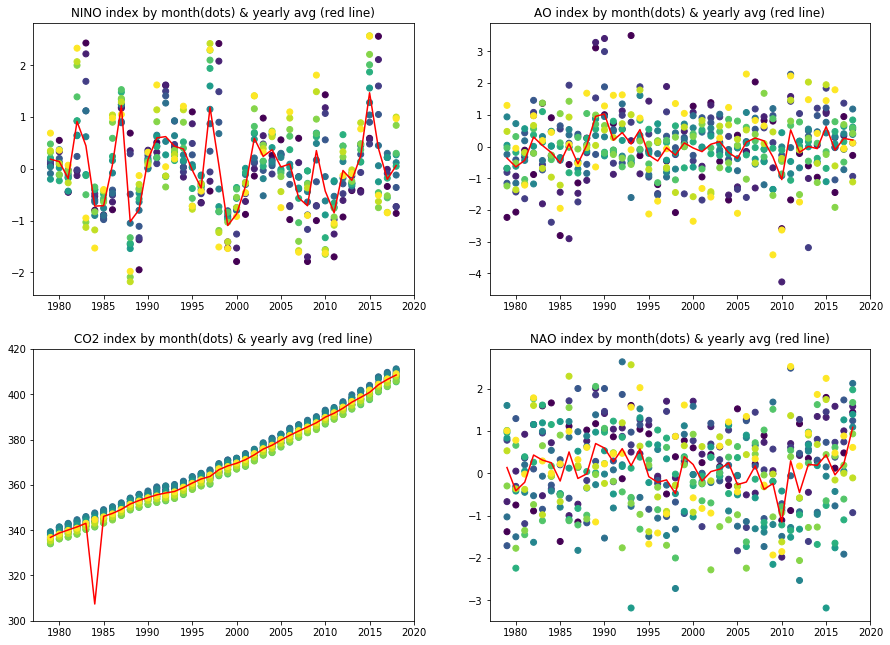

In [548]:
df_yr_mean = df.groupby('Year').mean().reset_index()
fig, axes = plt.subplots(nrows=2, ncols=2 , figsize=(15, 11))
plt.subplot(2, 2, 1)
plt.scatter(df['Year'], df['NINO'], c = df['Month'])
plt.plot(df_yr_mean['Year'], df_yr_mean['NINO'], color = 'red')
plt.legend
plt.title('NINO index by month(dots) & yearly avg (red line)')

plt.subplot(2, 2, 2)
plt.scatter(df['Year'], df['AO'], c = df['Month'])
plt.plot(df_yr_mean['Year'], df_yr_mean['AO'], color = 'red')
plt.legend
plt.title('AO index by month(dots) & yearly avg (red line)')

plt.subplot(2, 2, 3)
axes = plt.gca()
axes.set_ylim([300, 420])
plt.scatter(df['Year'], df['CO2'], c = df['Month'])
plt.plot(df_yr_mean['Year'], df_yr_mean['CO2'], color = 'red')
plt.legend
plt.title('CO2 index by month(dots) & yearly avg (red line)')

plt.subplot(2, 2, 4)
plt.scatter(df['Year'], df['NAO'], c = df['Month'])
plt.plot(df_yr_mean['Year'], df_yr_mean['NAO'], color = 'red')
plt.legend
plt.title('NAO index by month(dots) & yearly avg (red line)')


In [549]:
# See http://mlg.eng.cam.ac.uk/carl/words/carbon.html for more details about CO2 growth rate.
## The monthly repeating variation in CO2 is due to 
## 'plants taking up more carbon dioxide in the summer than in winter'

In [550]:
# --> dip in CO2 is due to one month with missing value (-99.99)

### Let's turn to look at seasonal behavior of sea ice

Text(0.5,1,u'Sea ice concentration by month (1986-1987)')

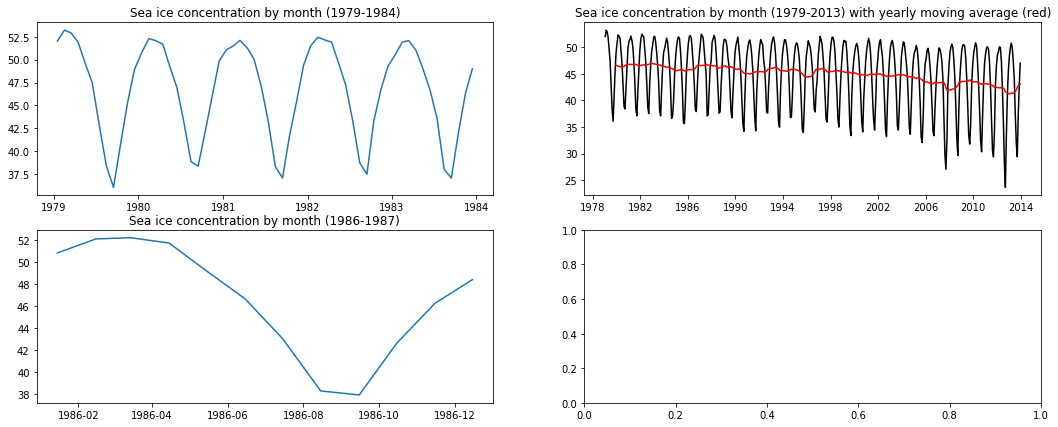

In [551]:
fig, axes = plt.subplots(nrows=2, ncols=2 , figsize=(18, 7))
plt.subplot(2, 2, 1)
da9 = sea_ice.sel(time=slice('1979-01-01', '1984-01-01'))
dd = da9.to_dataframe().reset_index()
dt = dd[dd['seaice_conc'] != -1]
dt1 = dt[['time', 'seaice_conc']].groupby('time').mean().reset_index()
plt.plot(dt1['time'], dt1['seaice_conc'])
plt.title('Sea ice concentration by month (1979-1984)')

plt.subplot(2, 2, 2)
dl = sea_ice.to_dataframe().reset_index()
dl = dl[dl['seaice_conc'] != -1]
dl = dl[['time', 'seaice_conc']].groupby('time').mean().reset_index()
dl['MA'] = dl['seaice_conc'].rolling(window=12).mean()
plt.plot(dl['time'], dl['seaice_conc'], color = 'black')
plt.plot(dl['time'], dl['MA'], color = 'red')
plt.title('Sea ice concentration by month (1979-2013) with yearly moving average (red)')

plt.subplot(2, 2, 3)
da9 = sea_ice.sel(time=slice('1986-01-01', '1987-01-01'))
dd = da9.to_dataframe().reset_index()
dt = dd[dd['seaice_conc'] != -1]
dt1 = dt[['time', 'seaice_conc']].groupby('time').mean().reset_index()
plt.plot(dt1['time'], dt1['seaice_conc']) 
plt.title('Sea ice concentration by month (1986-1987)')


From the figures above we can see that the overall trend of sic goes down (red).
Further, from both figures on the left we see clear seasonality patterns, which seem to follow summertime-wintertime.
However these figures are an aggregate over all latitude/longitude combinations. One can decide (e.g. prior knowledge/ k-means) on interest areas and construct a per area seasonality features (by finding lags - e.g. diffrencing, auto-correlation function). Another option (which I use) is to construct several naive features that seem to be appropriate on the aggregated level. These choosen features could be extended as needed.
 
Features chosen:
1. month
2. same month last year 
3. weighted avg same month last 3 years value (0.5, 0.3, 0.2)
4. last 3 months 
5. last 6 months 
6. last 12 months 

### Figures showing sea ice concentration and focus area (for modelling) respectively

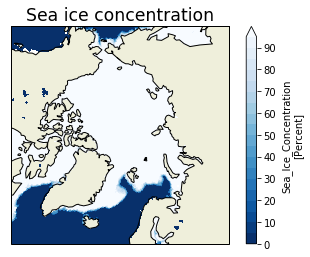

/Users/omer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]
/Users/omer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/Users/omer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


Text(0.5,1,u'0=ocean, 1=sea ice')

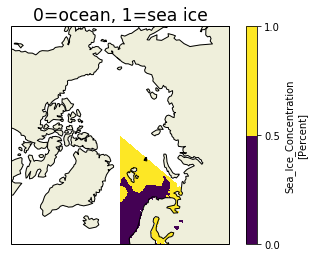

In [552]:
plt.subplot(1, 2, 1)
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
sea_ice.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=range(0,100,5),
                              cmap='Blues_r', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('Sea ice concentration', size='xx-large')
plt.show()

plt.subplot(1, 2, 2)
da = xr.DataArray.copy(sea_ice_s)
da.values[ (da.values >= 0) & (da.values < 15.)] = 0.
da.values[ da.values >= 15. ]                    = 1.
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
da.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=[0,0.5,1],
                              cmap='viridis', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('0=ocean, 1=sea ice', size='xx-large')

## Model
Why I chose the regression tree based models - see Readme.md file 

In [582]:
def train_test(feat_df, sic_df, model, ch_feat ,lon, lat):
## Uncomment to write to a file - adding long time to run
#     with open(model + '_.csv', 'wb') as csvfile:
#         wr = csv.writer(csvfile,  delimiter='\t',  lineterminator='\n')
#         wr.writerow(['Model', "tr_rmse", "te_rmse", "lat", "lon", "features", "feat_importance", "model_spec"])
        start = time.time()
        te_err = []; tr_err = []; count = 0 
        
        for i in range(0, nlons):
            for j in range(0, nlats):


                if mask[j, i] == False:

                    sic_filt = sic_df.isel(latitude = j, longitude = i).to_dataframe().reset_index()
                    ## if all vals are equal, the tree is meaningless
                    if (np.all(sic_filt['seaice_conc'] == sic_filt['seaice_conc'][1])):
                        break
                    df1  = pd.merge(feat_df, sic_filt)
                    df1 = add_seasonal_feat(df1)
                    
                    # ensure no nan values
                    df1 = df1[df1['Year'] > 1982]
                    
                    X   = df1[ch_feat].values
                    Y   = df1['seaice_conc'].values
                    yrs = df1['Year'].values
                    ### Split data into training and testing datasets
                    X_train, X_test, Y_train, Y_test = tr_te_split(X, Y, yrs, 2010)
                    
                    
                    # Set all slots to -1 and update them in prediction section below
                    if count == 0:
                        Y_pred_3d = np.ones( (Y_test.shape[0], nlats, nlons) ) * -1
                        Y_test_3d = np.ones( (Y_test.shape[0], nlats, nlons) ) * -1
                        
                    Y_test_3d[:, j, i] = Y_test                    
                    #####################
                    ### Regressor model
                    #####################
                    if(model == 'simple'):
                        Y_pred_3d[:, j, i] = Y_test.mean()
                        predicted = Y_test.mean()
                        curr_tr_err = 'None'; clf = 'None'; important ='None';
                    else:
                        if(model == 'tree'):
                            clf = tree.DecisionTreeRegressor()
                        elif(model == 'random_for'):
                            clf = ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=4)
                        else:
                            clf = ensemble.GradientBoostingRegressor(n_estimators=100, min_samples_leaf=5, max_features=4)
                        clf = clf.fit(X_train, Y_train)
                        # Prediction 
                        Y_pred_3d[:, j, i] = clf.predict(X_test)
                        predicted = clf.predict(X_test)
                        # Loss calculation
                        curr_tr_err = rmse(Y_train, clf.predict(X_train))
                        important = clf.feature_importances_
                    
                    curr_te_err = rmse(Y_test, predicted)
                    te_err.append(curr_te_err); tr_err.append(curr_tr_err); 
                    # Write to file - uncomment - this will add a lot of time to the run
                    # wr.writerow([model, curr_tr_err, curr_te_err, j, i, ch_feat, important, str(clf)])
                    count = count + 1

        if(model=='simple'):
            _tr_err = None
        else:
            _tr_err = np.mean(tr_err)
        end = time.time()    
        print('Model:', model)
        print('Training took:' + str((end - start) / 60) + ' ' + 'minutes')
        print(str(clf).replace('\n','').replace(' ', ''))
        print('test error is:', np.mean(te_err))
        print('train error is:',_tr_err )
        return model, _tr_err, np.mean(te_err), str((end - start) / 60)   

## Evaluation

In [583]:
feat_df = df; sic_df = sea_ice_s;
def main():
    results = {'Model': ['-'], 'Training error': ['-'], 'Test error': ['-'], 'Features':['-'], 'Runtime': ['-']}
    results_pd = pd.DataFrame(data = results)
    models = ['simple', 'tree', 'random_for', 'xgb']
    nlons = sea_ice_s.longitude.shape[0]; nlats = sea_ice_s.latitude.shape[0]
    ch_feat = {'simple': ['wheight_avg_same_mon_prev_3yr'], 
               'seas_only': ['Month', 'same_mon_prev_yr', 'prev_three_mon', 'prev_six_mon', 'prev_yr', 'wheight_avg_same_mon_prev_3yr'], 
               'modes_only':  ['NAO', 'NINO','AO', 'CO2'],
               'alll': ['Month', 'NAO', 'NINO','AO', 'CO2', 'same_mon_prev_yr', 'prev_three_mon', 'prev_six_mon', 'prev_yr', 'wheight_avg_same_mon_prev_3yr']}
    
    for model in models:
        for feat in ch_feat:
            
            if ((model != 'simple') & (feat == 'simple')):
                continue
                
            _model, _tr_err, _te_err, _runtime = train_test(feat_df, sic_df, model, ch_feat[feat], nlons, nlats)
            
#             if(model !='simple'):
#                 _tr_err = round(_tr_err, 3)
#                 _te_err = round(_te_err, 3)
            
            results_pd = results_pd.append(pd.DataFrame({'Model': [_model], 'Training error': [str(_tr_err)], 
                                            'Test error': [str(_te_err)], 'Features':[str(feat)], 'Runtime': [_runtime]}))
            
            if(model == 'simple'):
                break
    return results_pd

In [584]:
eval_df = main()

('Model:', 'simple')
Training took:5.20395213366 minutes
None
('test error is:', 14.274197)
('train error is:', None)
('Model:', 'tree')
Training took:5.34911135038 minutes
DecisionTreeRegressor(criterion='mse',max_depth=None,max_features=None,max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,presort=False,random_state=None,splitter='best')
('test error is:', 14.909389878145971)
('train error is:', 0.8829879955105197)
('Model:', 'tree')
Training took:5.8159158349 minutes
DecisionTreeRegressor(criterion='mse',max_depth=None,max_features=None,max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,presort=False,random_state=None,splitter='best')
('test error is:', 16.472224063094963)
('train error is:', 0.0)
('Model:', 'tree')
Training took:5.49267604748 minutes
DecisionTreeRegressor(criterion='mse',max_depth=None,max_fe

In [585]:
eval_df.reset_index(drop=True)

,Features,Model,Runtime,Test error,Training error
0,-,-,-,-,-
1,simple,simple,5.20395213366,14.274197,None
2,seas_only,tree,5.34911135038,14.909389878145971,0.8829879955105197
3,alll,tree,5.8159158349,16.472224063094963,0.0
4,modes_only,tree,5.49267604748,21.196692113464756,0.0
5,seas_only,random_for,72.2091959675,11.09468991106357,8.443173742067088
6,alll,random_for,67.2930606683,11.300548252633288,8.175895094510475
7,modes_only,random_for,100.890585415,16.47312056183059,10.740739488278402
8,seas_only,xgb,9.68951445023,11.5686647014894,6.087124628042259
9,alll,xgb,10.108352685,12.003733141963254,5.15951406861741


In [ ]:
# --> Hard to beat the average
# --> Using only the modes (without further optimization) gives us worse results than average. 